### Step3A
### Identifying Authors based on message volumne and retweet avg / tweet and feature engineering to create new metrics

In [1]:
import os
import time
import subprocess

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/safzal1/finalprojectdata_AfterStep2")

In [5]:
df.count()

1731801

### Identify the most prolific / influential Twitterers

#### 1) By message volume (original content)
###### Selecting Retweeted == False, and if its False that means its original tweet


In [6]:
df.filter(col('RT_Status_RT_Count').isNull()).count()

170990

In [7]:
df.filter(col('If_Retweeted_Root') != 'RT').select(col('If_Retweeted_Root'), col('RT_Status_RT_Count')).limit(5)

If_Retweeted_Root,RT_Status_RT_Count
,null
,null
,null
,null
,null


###### All those which are RT in the Root Retweeted Column are corespondong to the RT_Status_RT_Count

In [8]:
df.filter(col('If_Retweeted_Root') == 'RT').select(col('If_Retweeted_Root'), col('RT_Status_RT_Count')).limit(5)

If_Retweeted_Root,RT_Status_RT_Count
RT,3
RT,10
RT,104
RT,34
RT,6


###### From the grouped by tabled below It is also evident that to filter out original tweets we should use Retweeted status in the root level

In [9]:
df.groupBy('If_Retweeted_Root').agg(count('RT_Status_RT_Count'))

If_Retweeted_Root,count(RT_Status_RT_Count)
,0
RT,1560811


###### This is from the RT_Status_Retweeted column which also corresponds

In [10]:
df.groupBy('If_Retweeted').agg(count('RT_Status_RT_Count'))

If_Retweeted,count(RT_Status_RT_Count)
null,0
false,1560811


##### To select Original Tweet We will use Retweeted Column where the value is not RT

In [11]:
df_original = df.filter(col('If_Retweeted_Root') != 'RT')

In [12]:
print("Total Number of Original tweets: ",df_original.count())

Total Number of Original tweets:  170849


In [13]:
total_tweets = df.count()
original_tweets = df_original.count()
RT_tweets = total_tweets - original_tweets

In [14]:
print("Total Number of Original tweets: ",total_tweets)

Total Number of Original tweets:  1731801


In [15]:
pd_df_tweets_original_RT = pd.DataFrame({'Original': [original_tweets], 'Retweeted': [RT_tweets]}).transpose()

In [16]:
pd_df_tweets_original_RT.set_axis(['Tweets'], axis = 1, inplace = True)

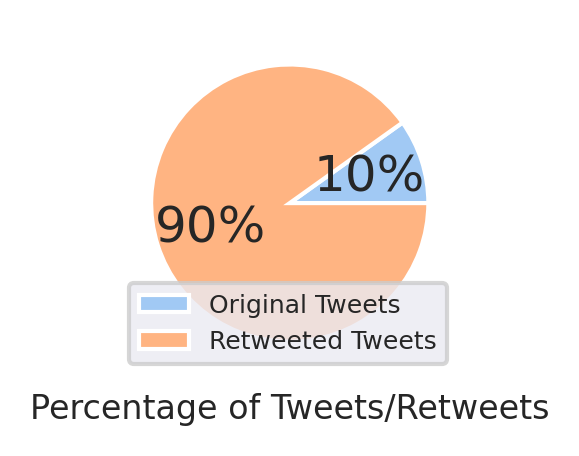

In [81]:
plt.figure(figsize=(1.5,1.5), dpi=300)
colors = sns.color_palette('pastel')[0:5]
plt.pie(pd_df_tweets_original_RT.Tweets, colors = colors, autopct='%.0f%%')
plt.legend(['Original Tweets', 'Retweeted Tweets'], fontsize = 6)
plt.xlabel('Percentage of Tweets/Retweets', fontsize = 8)
plt.show()

In [18]:
original_tweet_profile_count = df_original.groupBy(col('User_ID'), col('User_Name')).agg(count('Tweet_ID').alias('Tweet_Count'))\
                    .orderBy('Tweet_Count', ascending = False)

In [19]:
original_tweet_profile_count.count()

117882

In [20]:
df_original_1 = df_original.groupBy(col('User_ID'), col('User_Name')).agg(count('Tweet_ID').alias('Tweet_Count'))\
                    .orderBy('Tweet_Count', ascending = False).limit(5)

In [21]:
df_original_1

User_ID,User_Name,Tweet_Count
961542553014190080,Shopyazanophu33,2425
889327405126397957,getthatrightgtr,1147
1468164097355264002,group_kq,1019
1405231598530932737,nj_education,778
1473922978073165834,studyinnaija,685


In [22]:
df_original_1_pd = df_original_1.toPandas()

In [23]:
df_original_1_pd.drop(columns = ['User_Name'], inplace = True)

In [24]:
df_original_1_pd

,User_ID,Tweet_Count
0,961542553014190080,2425
1,889327405126397957,1147
2,1468164097355264002,1019
3,1405231598530932737,778
4,1473922978073165834,685


##### To understand better why they are the most influencer, we will identify their profiles

In [25]:
user_ids = df_original_1.select('User_ID').rdd.flatMap(lambda x: x).collect()

In [26]:
user_ids

[961542553014190080,
 889327405126397957,
 1468164097355264002,
 1405231598530932737,
 1473922978073165834]

In [27]:
### this dataframe contains tweets only from the top 5 original tweets by volume
df_original_2 = df_original.filter(col('User_ID').isin(user_ids))

In [28]:
df_original_AR = df_original_2.groupBy('User_ID', 'User_Name').agg(avg('User_Profile_Followers_Count').alias('Avg_Follower'),\
                                                                  avg('User_Tweets-Retweet_Count').alias('Avg_Activity'))

In [29]:
df_original_AR = df_original_AR.withColumn('AR', col('Avg_Activity') / col('Avg_Follower'))

In [30]:
df_original_AR_pd= df_original_AR.select('User_ID', 'AR').toPandas()

In [31]:
## Here we have all 5 top users profiles
pd_df_original_2 = df_original_2.dropDuplicates(['User_ID']).toPandas()

23/03/10 03:55:35 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [32]:
pd_df_original_2

,Tweet_ID,RT_Status_RT_Count,RT_Status_Like_Count,RT_Status_Reply_Count,RT_Stats_Quoted_Count,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,RT_Status_Original_User_Location,RT_Status_Original_User_Description,RT_Status_Original_User_Verified,...,User_ID_Creation_Date,RT_Mentioned_User_ID,Tweet_Location_Lat,Tweet_Location_Long,If_Retweeted,If_Retweeted_Root,Place_Country,Text,Tweet_Text,Tweet_Date
0,1610674477649608710,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,Mon Jul 24 03:32:31 +0000 2017,None,NaN,NaN,None,,None,Charter School vs Public School: What's the Di...,Charter School vs Public School: What's the Di...,Wed Jan 04 16:28:15 +0000 2023
1,1591215477824651277,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,Thu Feb 08 10:09:44 +0000 2018,None,NaN,NaN,None,,None,Education is what remains after one has forgot...,Education is what remains after one has forgot...,Fri Nov 11 23:45:07 +0000 2022
2,1519960946034286592,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,Thu Dec 23 07:47:44 +0000 2021,None,NaN,NaN,None,,None,PhD in Health Education at Ahmadu Bello Univer...,PhD in Health Education at Ahmadu Bello Univer...,Fri Apr 29 08:45:03 +0000 2022
3,1537103528367464450,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,Tue Dec 07 10:22:58 +0000 2021,None,NaN,NaN,None,,None,University of Birmingham appoints new Pro-Vice...,University of Birmingham appoints new Pro-Vice...,Wed Jun 15 16:03:33 +0000 2022
4,1587790841535512582,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,Wed Jun 16 18:38:24 +0000 2021,None,NaN,NaN,None,,None,Substitute Teacher - Preschool - Grade 8 in Ne...,Substitute Teacher - Preschool - Grade 8 in Ne...,Wed Nov 02 12:56:51 +0000 2022


In [33]:
pd_df_original_2 = pd.merge(pd_df_original_2,df_original_1_pd, on = 'User_ID' )

In [34]:
pd_df_original_2 = pd.merge(pd_df_original_2,df_original_AR_pd, on = 'User_ID' )

In [35]:
pd_df_original_2.sort_values(by='Tweet_Count', ascending = False, inplace = True)

In [36]:
pd_df_original_2

,Tweet_ID,RT_Status_RT_Count,RT_Status_Like_Count,RT_Status_Reply_Count,RT_Stats_Quoted_Count,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,RT_Status_Original_User_Location,RT_Status_Original_User_Description,RT_Status_Original_User_Verified,...,Tweet_Location_Lat,Tweet_Location_Long,If_Retweeted,If_Retweeted_Root,Place_Country,Text,Tweet_Text,Tweet_Date,Tweet_Count,AR
1,1591215477824651277,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,NaN,NaN,None,,None,Education is what remains after one has forgot...,Education is what remains after one has forgot...,Fri Nov 11 23:45:07 +0000 2022,2425,1281.827598
0,1610674477649608710,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,NaN,NaN,None,,None,Charter School vs Public School: What's the Di...,Charter School vs Public School: What's the Di...,Wed Jan 04 16:28:15 +0000 2023,1147,842.213612
3,1537103528367464450,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,NaN,NaN,None,,None,University of Birmingham appoints new Pro-Vice...,University of Birmingham appoints new Pro-Vice...,Wed Jun 15 16:03:33 +0000 2022,1019,1412.364334
4,1587790841535512582,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,NaN,NaN,None,,None,Substitute Teacher - Preschool - Grade 8 in Ne...,Substitute Teacher - Preschool - Grade 8 in Ne...,Wed Nov 02 12:56:51 +0000 2022,778,345.747669
2,1519960946034286592,NaN,NaN,NaN,NaN,NaN,None,None,None,None,...,NaN,NaN,None,,None,PhD in Health Education at Ahmadu Bello Univer...,PhD in Health Education at Ahmadu Bello Univer...,Fri Apr 29 08:45:03 +0000 2022,685,708.740603


In [37]:
pd_df_original_2_melted = pd.melt(pd_df_original_2, id_vars=['User_Name'], \
                                  value_vars=[
                                              'Tweet_Count',\
                                                'User_Profile_Followers_Count', \
                                             'User_List_Count'],var_name='Y')

##### Here we are doing comparison for the top 5 profiles

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_9446/919352731.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


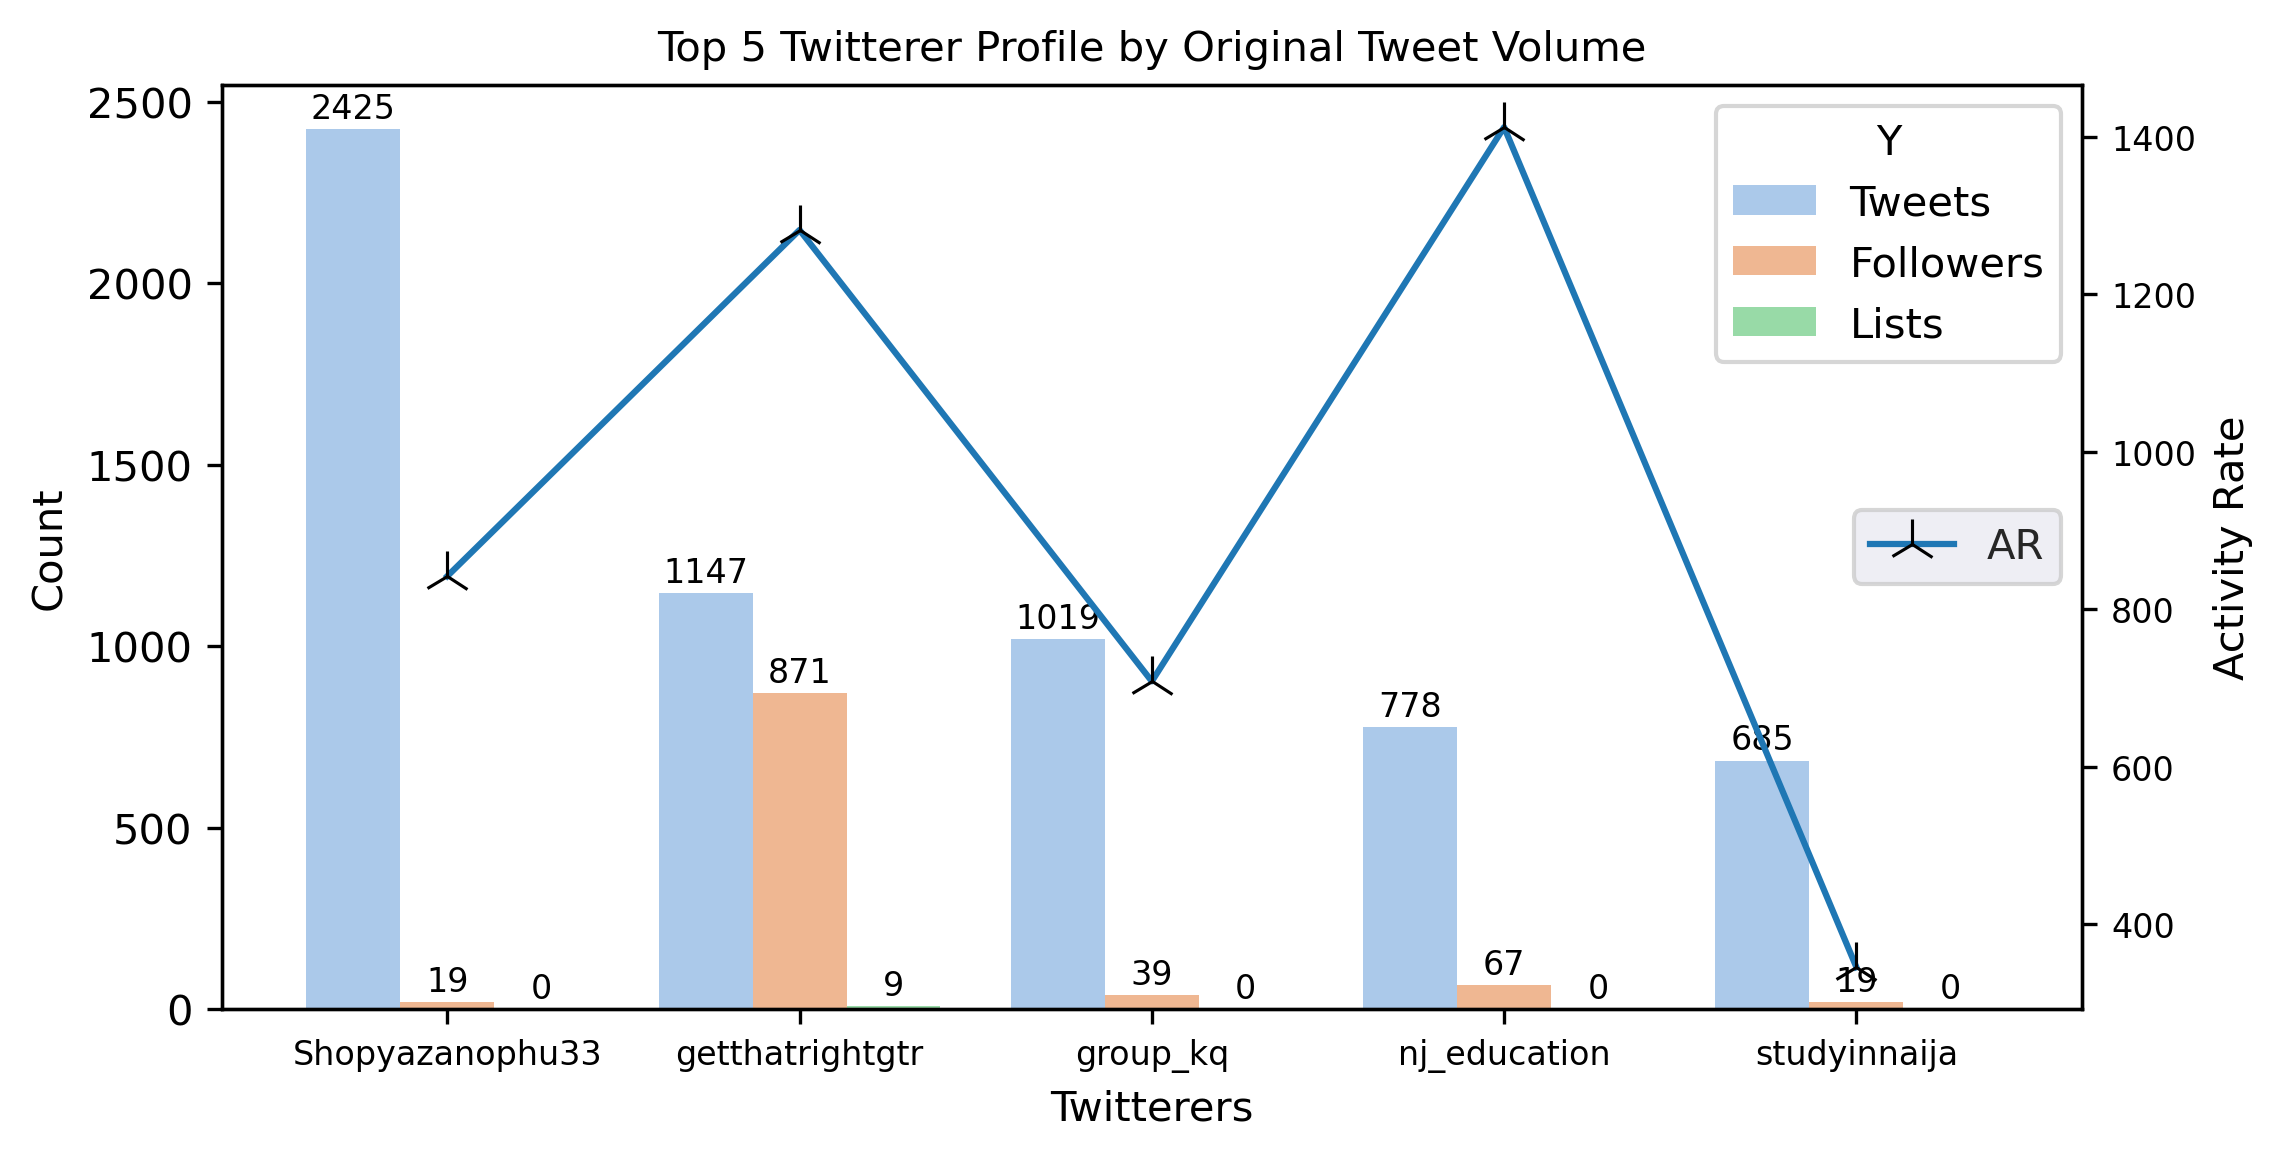

In [38]:
plt.figure(figsize=(8,4), dpi=300)
colors = sns.color_palette('pastel')[0:5]
ax = sns.barplot(x = 'User_Name', y = 'value', hue = 'Y', data = pd_df_original_2_melted, palette = colors)
ax2=ax.twinx()
ax2 = sns.lineplot(pd_df_original_2_melted.User_Name, pd_df_original_2.AR, label = 'AR' ,marker = '2', markersize = 12
            , markeredgecolor = 'Black')
plt.title('Top 5 Twitterer Profile by Original Tweet Volume', fontsize = 10)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=8, padding=1)

sns.set(rc={'legend.fontsize': 10})
new_labels = {'Y1': 'Tweets', 'Y2': 'Followers', 'Y3': 'Lists'}
for t, l in zip(ax.legend_.texts, new_labels.values()):
    t.set_text(l)    
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.yticks(fontsize = 8)
plt.xlabel('Users', fontsize = 10)
ax2.set_ylabel('Activity Rate', fontsize = 10)
ax.set_ylabel('Count', fontsize = 10)
ax.set_xlabel('Twitterers', fontsize = 10)
ax2.grid(visible=False)
ax2.legend(loc = 'center right')


plt.show()

##### Surprisinly all the top twitterers by original content volume are all not verified, Now we will look into if these were verified twitters, how would their counts would be

### From here we are analysing only verified twitters

In [40]:
df_original_verified = df_original.filter(col('User_Verified') == True)

In [42]:
df_original_verified.limit(2)

Tweet_ID,RT_Status_RT_Count,RT_Status_Like_Count,RT_Status_Reply_Count,RT_Stats_Quoted_Count,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,RT_Status_Original_User_Location,RT_Status_Original_User_Description,RT_Status_Original_User_Verified,RT_Status_Original_User_followers_count,RT_Status_Original_User_statuses_count,RT_Status_Original_User_listed_count,RT_Status_Original_Tweet_Id,RT_Status_Original_Tweet_Text,RT_Status_Original_Tweet_Created_at,Parsed_Hashtags,User_ID,User_Name,User_Defined_Location,User_Description,User_Verified,User_Profile_Followers_Count,User_Tweets-Retweet_Count,User_List_Count,User_ID_Creation_Date,RT_Mentioned_User_ID,Tweet_Location_Lat,Tweet_Location_Long,If_Retweeted,If_Retweeted_Root,Place_Country,Text,Tweet_Text,Tweet_Date
1524674512020807683,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[],34324846,ScienceCareers,"Washington, DC",Science Careers i...,true,73232,79198,594,Wed Apr 22 16:51:...,null,null,null,null,,null,Director for Phar...,Director for Phar...,Thu May 12 08:55:...
1550099249106493441,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,[],413428207,DailyPostNGR,Nigeria,Get the latest Ni...,true,1947443,565738,1314,Tue Nov 15 21:42:...,null,null,null,null,,null,UTME: Education M...,UTME: Education M...,Thu Jul 21 12:43:...


In [41]:
print('count of original tweets for verified user', df_original_verified.count())

count of original tweets for verified user 4051


In [51]:
verified = df_original_verified.count()
not_verified = df_original.filter(col('User_Verified') == False).count()

In [52]:
print('count of original tweets for not verified user', not_verified)

count of original tweets for not verified user 166798


In [70]:
pd_df_tweets_original_verified_not_verified = pd.DataFrame({'Verified': [verified],
                            
                                                  'Not Verified': [not_verified]}).transpose()

In [71]:
pd_df_tweets_original_verified_not_verified.set_axis(['Status'], axis = 1, inplace = True)

In [72]:
pd_df_tweets_original_verified_not_verified

,Status
Verified,4051
Not Verified,166798


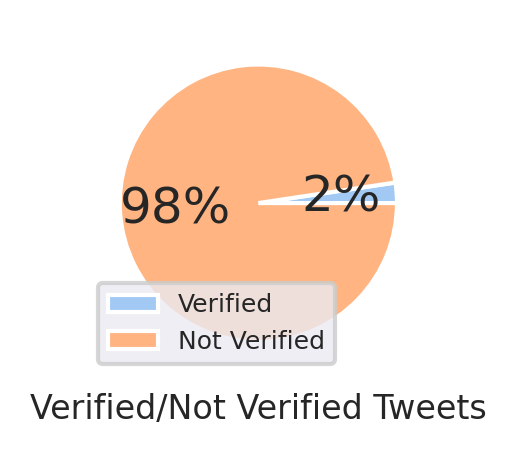

In [73]:
plt.figure(figsize=(1.5,1.5), dpi = 300)
colors = sns.color_palette('pastel')[0:5]
plt.pie(pd_df_tweets_original_verified_not_verified.Status, colors = colors, autopct='%.0f%%')
plt.legend(['Verified', 'Not Verified'], fontsize = 6, loc='lower left')
plt.xlabel('Verified/Not Verified Tweets', fontsize = 8)
plt.show()


### Counting verified user and non verified users

In [74]:
verified_user = df_original_verified.dropDuplicates(['User_ID']).count()
not_verified_user = df_original.dropDuplicates(['User_ID']).filter(col('User_Verified') == False).count()

In [75]:
print('count of original tweets for not verified user', not_verified_user)

count of original tweets for not verified user 115292


In [76]:
pd_df_user_original_verified_not_verified = pd.DataFrame({'Verified': [verified_user],
                            
                                                  'Not Verified': [not_verified_user]}).transpose()

In [77]:
pd_df_user_original_verified_not_verified.set_axis(['Status'], axis = 1, inplace = True)

In [78]:
pd_df_user_original_verified_not_verified

,Status
Verified,2395
Not Verified,115292


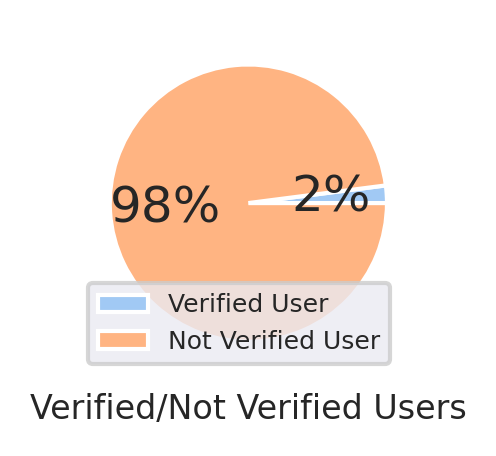

In [83]:
plt.figure(figsize=(1.5,1.5), dpi = 300)
colors = sns.color_palette('pastel')[0:5]
plt.pie(pd_df_user_original_verified_not_verified.Status, colors = colors, autopct='%.0f%%')
plt.legend(['Verified User', 'Not Verified User'], fontsize = 6, loc='lower left')
plt.xlabel('Verified/Not Verified Users', fontsize = 8)
plt.show()


In [106]:
df_original_verified_1 = df_original_verified.groupBy(col('User_ID'), col('User_Name')).agg(count('Tweet_ID').alias('Tweet_Count'))\
                    .orderBy('Tweet_Count', ascending = False).limit(5)

In [153]:
df_original_verified_1

User_ID,User_Name,Tweet_Count
30846824,TOICitiesNews,30
81136269,MiddleEastMnt,29
1367531,FoxNews,28
55118251,OUSDNews,27
274793711,EdSurge,27


In [154]:
df_original_verified_1_pd = df_original_verified_1.toPandas()

In [155]:
df_original_verified_1_pd.drop(columns = ['User_ID']).transpose()

,0,1,2,3,4
User_Name,TOICitiesNews,MiddleEastMnt,FoxNews,EdSurge,OUSDNews
Tweet_Count,30,29,28,27,27


##### So far we have concluded that the verified users are mostly the News Channels and these are not tweeting a lot on topic of education, the counts are significantly different and Which are not verified have higher count and those are also having good number of tweets/retweets interaction and followers and some are in lists as well

### Now we will move towards finding Best twitterers by how many times there messages are retweeted

In [315]:
## this is my dataframe which has RTed tweets
df_RT = df.filter(col('If_Retweeted_Root') == 'RT')

In [316]:
print('count of tweets which are RT is: ', df_RT.count())

count of tweets which are RT is:  1560952


###### Checking by volume of RT count
###### I have User ID on which the tweet was retweeted and from there I will see how many retweet counts do they have

In [317]:
df_RT.limit(2)

Tweet_ID,RT_Status_RT_Count,RT_Status_Like_Count,RT_Status_Reply_Count,RT_Stats_Quoted_Count,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,RT_Status_Original_User_Location,RT_Status_Original_User_Description,RT_Status_Original_User_Verified,RT_Status_Original_User_followers_count,RT_Status_Original_User_statuses_count,RT_Status_Original_User_listed_count,RT_Status_Original_Tweet_Id,RT_Status_Original_Tweet_Text,RT_Status_Original_Tweet_Created_at,Parsed_Hashtags,User_ID,User_Name,User_Defined_Location,User_Description,User_Verified,User_Profile_Followers_Count,User_Tweets-Retweet_Count,User_List_Count,User_ID_Creation_Date,RT_Mentioned_User_ID,Tweet_Location_Lat,Tweet_Location_Long,If_Retweeted,If_Retweeted_Root,Place_Country,Text,Tweet_Text,Tweet_Date
1584720815165431808,98,126,23,4,978874381,MichiganFreedom,"Michigan, USA",First line of def...,false,3402,9020,49,1584545259203149826,NEW: The national...,Mon Oct 24 14:00:...,[],2854152665,GoldensRule13,"Michigan, USA","Child of God, fam...",false,5173,70988,18,Sat Nov 01 02:27:...,[102071743],null,null,false,RT,null,RT @MichiganFreed...,NEW: The national...,Tue Oct 25 01:37:...
1584720915551911937,13,11,2,0,1505134239221649409,PoojaRa86290940,null,Pooja,false,147,1300,0,1582739974520438785,If the recruitmen...,Wed Oct 19 14:26:...,[],1559057829616844800,jagdish99147039,null,null,false,16,656,0,Mon Aug 15 06:02:...,[],null,null,false,RT,null,RT @PoojaRa862909...,If the recruitmen...,Tue Oct 25 01:38:...


In [318]:
df_RT_1 = df_RT.groupBy('RT_Status_Original_User_ID', 'RT_Status_Original_User_Screen_Name').\
                agg(avg('RT_Status_RT_Count').alias('Avg_Tweet/Tweet')).orderBy('Avg_Tweet/Tweet', ascending = False).limit(5)

In [319]:
df_RT_1

RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,Avg_Tweet/Tweet
782802921427644417,aambxt,230910.0
3235502126,jordannjust,147265.27272727274
2632900967,alsheaham,106857.0
3240330844,MakeItRayn_,73903.0
104040220,theestallion,66864.0


In [320]:
df_RT_1_pd = df_RT_1.toPandas()

In [321]:
df_RT_1_pd = df_RT_1_pd.round(1)
df_RT_1_pd

,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,Avg_Tweet/Tweet
0,782802921427644417,aambxt,230910.0
1,3235502126,jordannjust,147265.3
2,2632900967,alsheaham,106857.0
3,3240330844,MakeItRayn_,73903.0
4,104040220,theestallion,66864.0


In [322]:
df_RT_1_pd.drop(columns = ['RT_Status_Original_User_ID']).set_axis(['User_Name', 'Avg Retweets / Tweet'], axis = 1).transpose()

,0,1,2,3,4
User_Name,aambxt,jordannjust,alsheaham,MakeItRayn_,theestallion
Avg Retweets / Tweet,230910.0,147265.3,106857.0,73903.0,66864.0


In [323]:
df_RT_1_pd.drop(columns=['RT_Status_Original_User_Screen_Name'], inplace=(True))

In [324]:
user_RT_ids = df_RT_1.select('RT_Status_Original_User_ID').rdd.flatMap(lambda x: x).collect()

In [325]:
user_RT_ids

[782802921427644417, 3235502126, 2632900967, 3240330844, 104040220]

In [326]:
df.printSchema()

root
 |-- Tweet_ID: long (nullable = true)
 |-- RT_Status_RT_Count: long (nullable = true)
 |-- RT_Status_Like_Count: long (nullable = true)
 |-- RT_Status_Reply_Count: long (nullable = true)
 |-- RT_Stats_Quoted_Count: long (nullable = true)
 |-- RT_Status_Original_User_ID: long (nullable = true)
 |-- RT_Status_Original_User_Screen_Name: string (nullable = true)
 |-- RT_Status_Original_User_Location: string (nullable = true)
 |-- RT_Status_Original_User_Description: string (nullable = true)
 |-- RT_Status_Original_User_Verified: boolean (nullable = true)
 |-- RT_Status_Original_User_followers_count: long (nullable = true)
 |-- RT_Status_Original_User_statuses_count: long (nullable = true)
 |-- RT_Status_Original_User_listed_count: long (nullable = true)
 |-- RT_Status_Original_Tweet_Id: long (nullable = true)
 |-- RT_Status_Original_Tweet_Text: string (nullable = true)
 |-- RT_Status_Original_Tweet_Created_at: string (nullable = true)
 |-- Parsed_Hashtags: array (nullable = true)
 |  

In [327]:
#filtering on these top users
df_RT_2 = df_RT.filter(col('RT_Status_Original_User_ID').isin(user_RT_ids))

In [328]:
df_RT_2.count()

34

In [329]:
df_RT_AR = df_RT_2.groupBy('RT_Status_Original_User_ID', 'RT_Status_Original_User_Screen_Name').agg(avg('RT_Status_Original_User_followers_count').alias('Avg_Follower'),\
                                                                  avg('RT_Status_Original_User_statuses_count').alias('Avg_Activity'))

In [330]:
df_RT_AR = df_RT_AR.withColumn('AR', col('Avg_Activity') / col('Avg_Follower'))

In [331]:
df_RT_AR_pd = df_RT_AR.select('RT_Status_Original_User_ID','RT_Status_Original_User_Screen_Name','Avg_Follower','Avg_Activity', 'AR').toPandas()

In [332]:
df_RT_AR_pd

,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,Avg_Follower,Avg_Activity,AR
0,3235502126,jordannjust,1.791818e+04,24264.681818,1.354193
1,3240330844,MakeItRayn_,1.433900e+04,47721.000000,3.328056
2,782802921427644417,aambxt,1.028000e+03,245.285714,0.238605
3,2632900967,alsheaham,7.000000e+02,21898.000000,31.282857
4,104040220,theestallion,7.605122e+06,35436.000000,0.004659


In [333]:
pd_df_RT_2 = df_RT_2.dropDuplicates(['RT_Status_Original_User_ID']).toPandas()

In [334]:
pd.set_option('display.max_columns', None)

In [335]:
pd_df_RT_2

,Tweet_ID,RT_Status_RT_Count,RT_Status_Like_Count,RT_Status_Reply_Count,RT_Stats_Quoted_Count,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,RT_Status_Original_User_Location,RT_Status_Original_User_Description,RT_Status_Original_User_Verified,RT_Status_Original_User_followers_count,RT_Status_Original_User_statuses_count,RT_Status_Original_User_listed_count,RT_Status_Original_Tweet_Id,RT_Status_Original_Tweet_Text,RT_Status_Original_Tweet_Created_at,Parsed_Hashtags,User_ID,User_Name,User_Defined_Location,User_Description,User_Verified,User_Profile_Followers_Count,User_Tweets-Retweet_Count,User_List_Count,User_ID_Creation_Date,RT_Mentioned_User_ID,Tweet_Location_Lat,Tweet_Location_Long,If_Retweeted,If_Retweeted_Root,Place_Country,Text,Tweet_Text,Tweet_Date
0,1578423972882178049,107054,448777,548,2367,2632900967,alsheaham,"Nashville, TN",god’s shittiest miracle,False,705,21863,3,1273431132407771140,My favorite thing ever is when people say that...,Thu Jun 18 01:43:35 +0000 2020,[],228660682,dgr8furea,None,A BLANK CANVAS,False,25,143,0,Mon Dec 20 09:55:00 +0000 2010,[],NaN,NaN,False,RT,None,RT @alsheaham: My favorite thing ever is when ...,My favorite thing ever is when people say that...,Fri Oct 07 16:36:15 +0000 2022
1,1527621773319184385,148271,370472,3937,31539,3235502126,jordannjust,None,jordannjustfitness@gmail.com art• music• earth...,False,18061,24051,22,1120758262675202050,PLEASE WATCH! SEX EDUCATION OUR SCHOOL SYSTEM(...,Tue Apr 23 18:36:07 +0000 2019,[],1604104238,ManokFree,"Nairobi, Kenya","self satisfaction, expression and adventure to...",False,724,3824,5,Thu Jul 18 18:54:12 +0000 2013,[],NaN,NaN,False,RT,None,RT @jordannjust: PLEASE WATCH! SEX EDUCATION O...,PLEASE WATCH! SEX EDUCATION OUR SCHOOL SYSTEM(...,Fri May 20 12:06:27 +0000 2022
2,1564495955281453056,67261,243330,872,1821,104040220,theestallion,HTX,thee real Htown Hottie 😛,True,7609732,35410,3114,1271590677344710656,Although school is not for everyone do not let...,Fri Jun 12 23:50:17 +0000 2020,[],1397106261611659267,AKISTALLI,Pansexual❤️‍🔥,-fan account- ( 18 ) ~ they/them~gossip girl a...,False,1904,20705,17,Tue May 25 08:24:54 +0000 2021,[],NaN,NaN,False,RT,None,RT @theestallion: Although school is not for e...,Although school is not for everyone do not let...,Tue Aug 30 06:11:17 +0000 2022
3,1540604130749624320,231784,957593,1429,10297,782802921427644417,aambxt,"California, USA",BLM,False,1035,246,0,1267599302618046464,parents push u for a college education and the...,Mon Jun 01 23:29:59 +0000 2020,[],709656131099074561,clearlycrystalz,Fayetteville,UA ‘24 🐗,False,207,40,0,Tue Mar 15 08:23:01 +0000 2016,[],NaN,NaN,False,RT,None,RT @aambxt: parents push u for a college educa...,parents push u for a college education and the...,Sat Jun 25 07:53:42 +0000 2022
4,1524048987766112263,73903,240286,369,824,3240330844,MakeItRayn_,Occupied Lenape Territory,Purdue | @/JamesGetsPolitical on TikTok | he/h...,False,14339,47721,37,1126638426151956480,If you want to reduce abortion rates:\n\n-Make...,Fri May 10 00:01:47 +0000 2019,[],2159933294,murphykatelyn11,None,this is just a taylor swift fan account at thi...,False,219,7116,2,Mon Oct 28 01:01:05 +0000 2013,[],NaN,NaN,False,RT,None,RT @MakeItRayn_: If you want to reduce abortio...,If you want to reduce abortion rates:\n\n-Make...,Tue May 10 15:29:28 +0000 2022


In [336]:
pd_df_RT_2 = pd.merge(pd_df_RT_2 , df_RT_1_pd , on = 'RT_Status_Original_User_ID')

In [337]:
pd_df_RT_2 = pd.merge(pd_df_RT_2 , df_RT_AR_pd , on = 'RT_Status_Original_User_ID')

In [338]:
pd_df_RT_2.sort_values(by = 'Avg_Tweet/Tweet', ascending = False, inplace = True)

In [339]:
pd_df_RT_2

,Tweet_ID,RT_Status_RT_Count,RT_Status_Like_Count,RT_Status_Reply_Count,RT_Stats_Quoted_Count,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name_x,RT_Status_Original_User_Location,RT_Status_Original_User_Description,RT_Status_Original_User_Verified,RT_Status_Original_User_followers_count,RT_Status_Original_User_statuses_count,RT_Status_Original_User_listed_count,RT_Status_Original_Tweet_Id,RT_Status_Original_Tweet_Text,RT_Status_Original_Tweet_Created_at,Parsed_Hashtags,User_ID,User_Name,User_Defined_Location,User_Description,User_Verified,User_Profile_Followers_Count,User_Tweets-Retweet_Count,User_List_Count,User_ID_Creation_Date,RT_Mentioned_User_ID,Tweet_Location_Lat,Tweet_Location_Long,If_Retweeted,If_Retweeted_Root,Place_Country,Text,Tweet_Text,Tweet_Date,Avg_Tweet/Tweet,RT_Status_Original_User_Screen_Name_y,Avg_Follower,Avg_Activity,AR
3,1540604130749624320,231784,957593,1429,10297,782802921427644417,aambxt,"California, USA",BLM,False,1035,246,0,1267599302618046464,parents push u for a college education and the...,Mon Jun 01 23:29:59 +0000 2020,[],709656131099074561,clearlycrystalz,Fayetteville,UA ‘24 🐗,False,207,40,0,Tue Mar 15 08:23:01 +0000 2016,[],NaN,NaN,False,RT,None,RT @aambxt: parents push u for a college educa...,parents push u for a college education and the...,Sat Jun 25 07:53:42 +0000 2022,230910.0,aambxt,1.028000e+03,245.285714,0.238605
1,1527621773319184385,148271,370472,3937,31539,3235502126,jordannjust,None,jordannjustfitness@gmail.com art• music• earth...,False,18061,24051,22,1120758262675202050,PLEASE WATCH! SEX EDUCATION OUR SCHOOL SYSTEM(...,Tue Apr 23 18:36:07 +0000 2019,[],1604104238,ManokFree,"Nairobi, Kenya","self satisfaction, expression and adventure to...",False,724,3824,5,Thu Jul 18 18:54:12 +0000 2013,[],NaN,NaN,False,RT,None,RT @jordannjust: PLEASE WATCH! SEX EDUCATION O...,PLEASE WATCH! SEX EDUCATION OUR SCHOOL SYSTEM(...,Fri May 20 12:06:27 +0000 2022,147265.3,jordannjust,1.791818e+04,24264.681818,1.354193
0,1578423972882178049,107054,448777,548,2367,2632900967,alsheaham,"Nashville, TN",god’s shittiest miracle,False,705,21863,3,1273431132407771140,My favorite thing ever is when people say that...,Thu Jun 18 01:43:35 +0000 2020,[],228660682,dgr8furea,None,A BLANK CANVAS,False,25,143,0,Mon Dec 20 09:55:00 +0000 2010,[],NaN,NaN,False,RT,None,RT @alsheaham: My favorite thing ever is when ...,My favorite thing ever is when people say that...,Fri Oct 07 16:36:15 +0000 2022,106857.0,alsheaham,7.000000e+02,21898.000000,31.282857
4,1524048987766112263,73903,240286,369,824,3240330844,MakeItRayn_,Occupied Lenape Territory,Purdue | @/JamesGetsPolitical on TikTok | he/h...,False,14339,47721,37,1126638426151956480,If you want to reduce abortion rates:\n\n-Make...,Fri May 10 00:01:47 +0000 2019,[],2159933294,murphykatelyn11,None,this is just a taylor swift fan account at thi...,False,219,7116,2,Mon Oct 28 01:01:05 +0000 2013,[],NaN,NaN,False,RT,None,RT @MakeItRayn_: If you want to reduce abortio...,If you want to reduce abortion rates:\n\n-Make...,Tue May 10 15:29:28 +0000 2022,73903.0,MakeItRayn_,1.433900e+04,47721.000000,3.328056
2,1564495955281453056,67261,243330,872,1821,104040220,theestallion,HTX,thee real Htown Hottie 😛,True,7609732,35410,3114,1271590677344710656,Although school is not for everyone do not let...,Fri Jun 12 23:50:17 +0000 2020,[],1397106261611659267,AKISTALLI,Pansexual❤️‍🔥,-fan account- ( 18 ) ~ they/them~gossip girl a...,False,1904,20705,17,Tue May 25 08:24:54 +0000 2021,[],NaN,NaN,False,RT,None,RT @theestallion: Although school is not for e...,Although school is not for everyone do not let...,Tue Aug 30 06:11:17 +0000 2022,66864.0,theestallion,7.605122e+06,35436.000000,0.004659


In [342]:
pd_df_RT_2_melted = pd.melt(pd_df_RT_2, id_vars=['RT_Status_Original_User_Screen_Name_x'], \
                                  value_vars=[
                                              'RT_Status_Original_User_statuses_count',\
                                                'RT_Status_Original_User_followers_count', \
                                            
                                             'RT_Status_Original_User_listed_count'],var_name='Y')

In [343]:
pd_df_RT_2_melted

,RT_Status_Original_User_Screen_Name_x,Y,value
0,aambxt,RT_Status_Original_User_statuses_count,246
1,jordannjust,RT_Status_Original_User_statuses_count,24051
2,alsheaham,RT_Status_Original_User_statuses_count,21863
3,MakeItRayn_,RT_Status_Original_User_statuses_count,47721
4,theestallion,RT_Status_Original_User_statuses_count,35410
5,aambxt,RT_Status_Original_User_followers_count,1035
6,jordannjust,RT_Status_Original_User_followers_count,18061
7,alsheaham,RT_Status_Original_User_followers_count,705
8,MakeItRayn_,RT_Status_Original_User_followers_count,14339
9,theestallion,RT_Status_Original_User_followers_count,7609732


/tmp/ipykernel_9446/4057971118.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


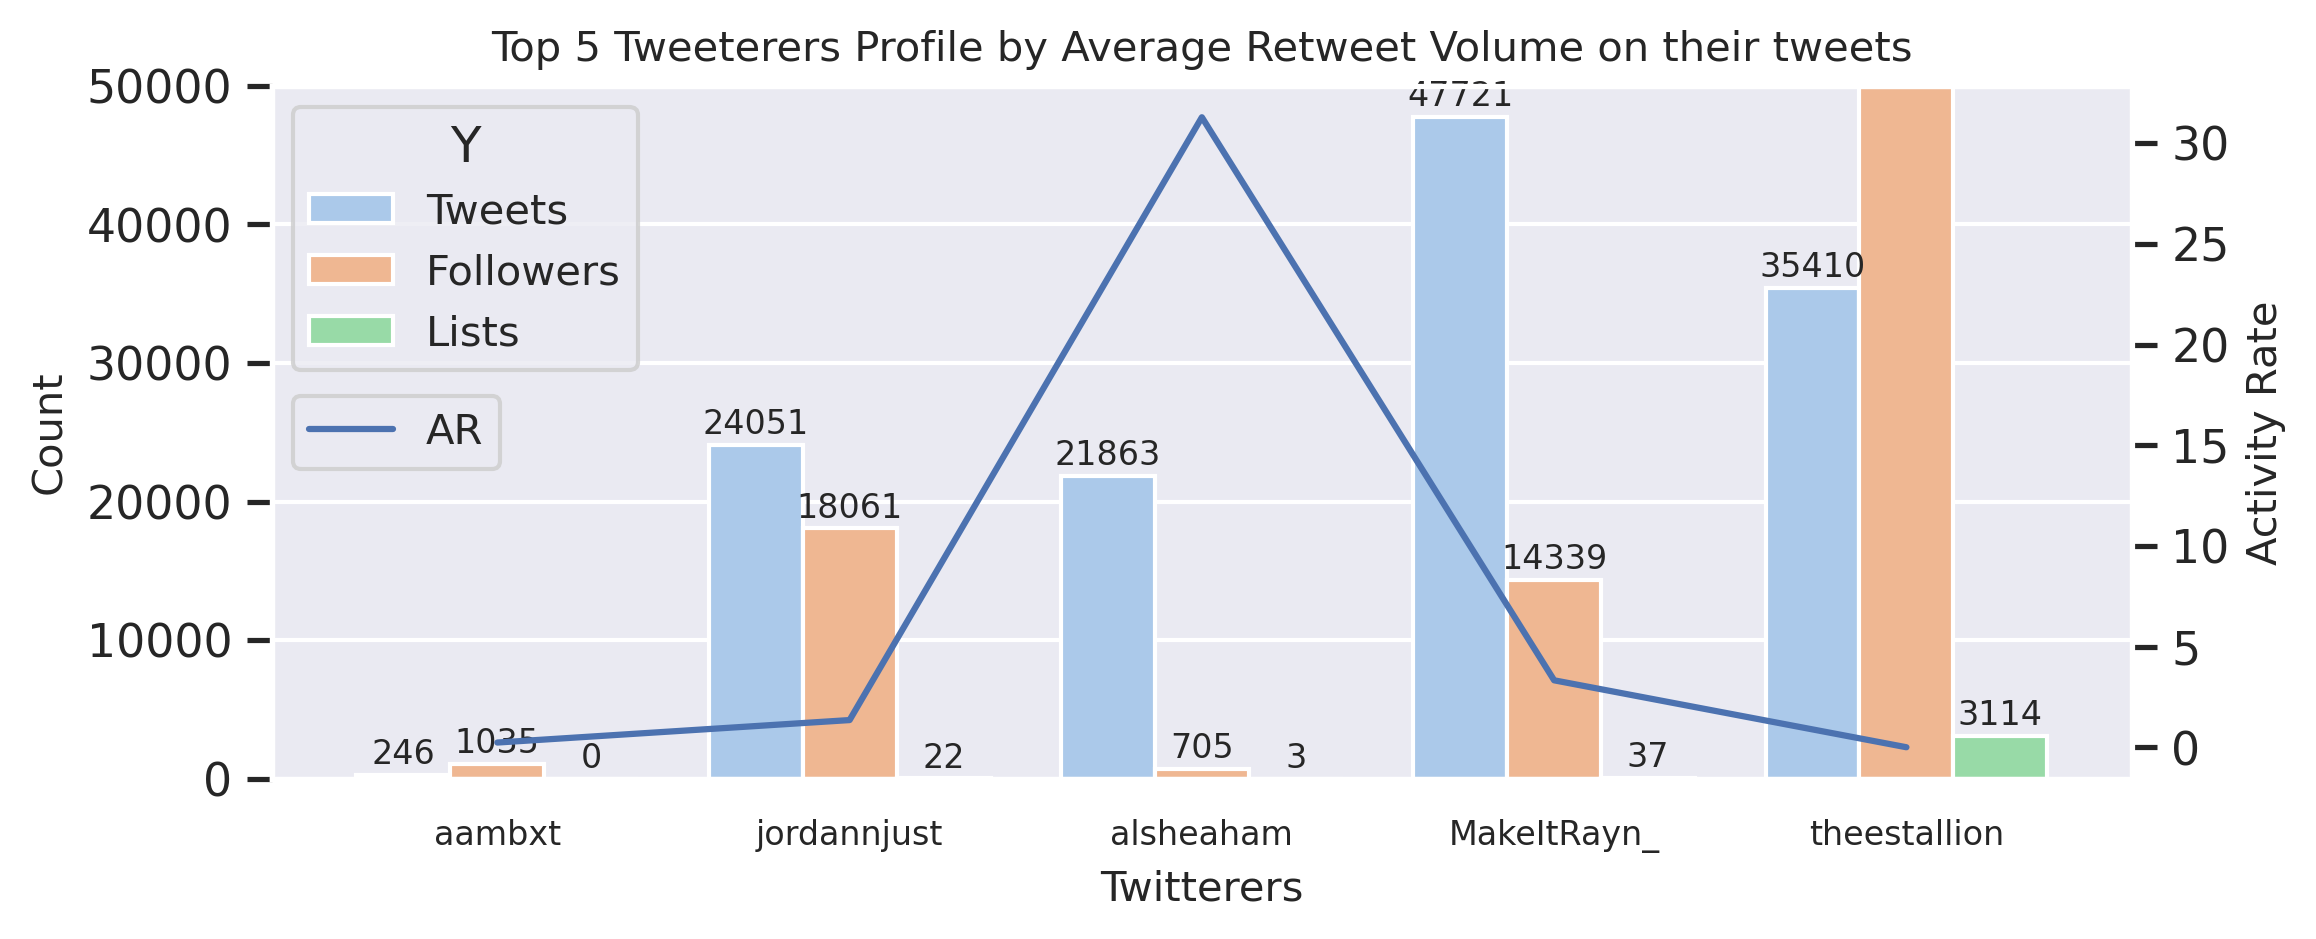

In [349]:
plt.figure(figsize=(8,3), dpi = 300)
colors = sns.color_palette('pastel')[0:5]

ax = sns.barplot(x = 'RT_Status_Original_User_Screen_Name_x', y = 'value', hue = 'Y', data = pd_df_RT_2_melted, palette = colors)
ax2=ax.twinx()

ax2 =sns.lineplot(x = pd_df_RT_2.RT_Status_Original_User_Screen_Name_x, y = pd_df_RT_2.AR, markersize = 12, label = 'AR', markeredgecolor = 'Black')

plt.title('Top 5 Tweeterers Profile by Average Retweet Volume on their tweets', fontsize = 10)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=8, padding=1)

sns.set(rc={'legend.fontsize': 10})
new_labels = {'Y1': 'Tweets', 'Y2': 'Followers', 'Y3': 'Lists'}
for t, l in zip(ax.legend_.texts, new_labels.values()):
    t.set_text(l)    
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax2.set_ylabel('Activity Rate', fontsize = 10)
ax.set_ylabel('Count', fontsize = 10)
ax.set_xlabel('Twitterers', fontsize = 10)
ax2.grid(visible=False)
ax2.legend(loc = 'center left')
ax2.set_xlabel('Twitterers', fontsize = 10)
ax.set_ylim(0, 50000)


plt.show()

#### finding egagement rate for all these top profiles
######  Activity rate for user: User_Tweets-Retweet_Count / Number of Followers
######  Engagement rate for user: (fav_count + reply_count + retweet_count) / Number of Followers

In [106]:
df_RT_AE2 = df_RT.filter(col('RT_Status_Original_User_followers_count') > 1)

In [107]:
df_RT_AE = df_RT_AE2.groupBy('RT_Status_Original_User_ID', 'RT_Status_Original_User_Screen_Name')\
                .agg(avg('RT_Status_Original_User_followers_count').alias('Avg_Followers'), avg('RT_Status_Original_User_statuses_count').alias('Avg_Status'),
                    avg('RT_Status_RT_Count').alias('Avg_RT_Count'), avg('RT_Status_Like_Count').alias('Avg_Like_Count'), avg('RT_Status_Reply_Count').alias('Avg_Reply_Count')
                    )

In [108]:
df_RT_AE = df_RT_AE.withColumn('AR',col('Avg_Status')/ col('Avg_Followers')).withColumn('ER', \
                            (col('Avg_RT_Count') + col('Avg_Like_Count') + col('Avg_Reply_Count')) / col('Avg_Followers' ))

In [109]:
df_RT_AE = df_RT_AE.filter(col('RT_Status_Original_User_Screen_Name') != 'TheBroccBurner')

In [110]:
df_RT_AE = df_RT_AE.filter(col('RT_Status_Original_User_Screen_Name') != 'ging3rbn')

In [111]:
df_RT_A_pd = df_RT_AE.orderBy('ER','AR', ascending = False).limit(5).toPandas()

In [112]:
df_RT_A_pd

,RT_Status_Original_User_ID,RT_Status_Original_User_Screen_Name,Avg_Followers,Avg_Status,Avg_RT_Count,Avg_Like_Count,Avg_Reply_Count,AR,ER
0,782802921427644417,aambxt,1028.00000,245.285714,230910.000000,954328.428571,1423.571429,0.238605,1154.340467
1,2632900967,alsheaham,700.00000,21898.000000,106857.000000,446927.000000,547.500000,31.282857,791.902143
2,624829360,MarshallShafer,538.47619,3458.095238,58716.095238,237795.714286,169.904762,6.422002,550.965334
3,1098823929601318912,kimberlyisNOT12,591.00000,2458.000000,35334.000000,174013.000000,553.000000,4.159052,355.160745
4,1562516095197581314,satnsnephew,3.00000,156.000000,5.000000,723.000000,2.000000,52.000000,243.333333


/tmp/ipykernel_9446/553016921.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


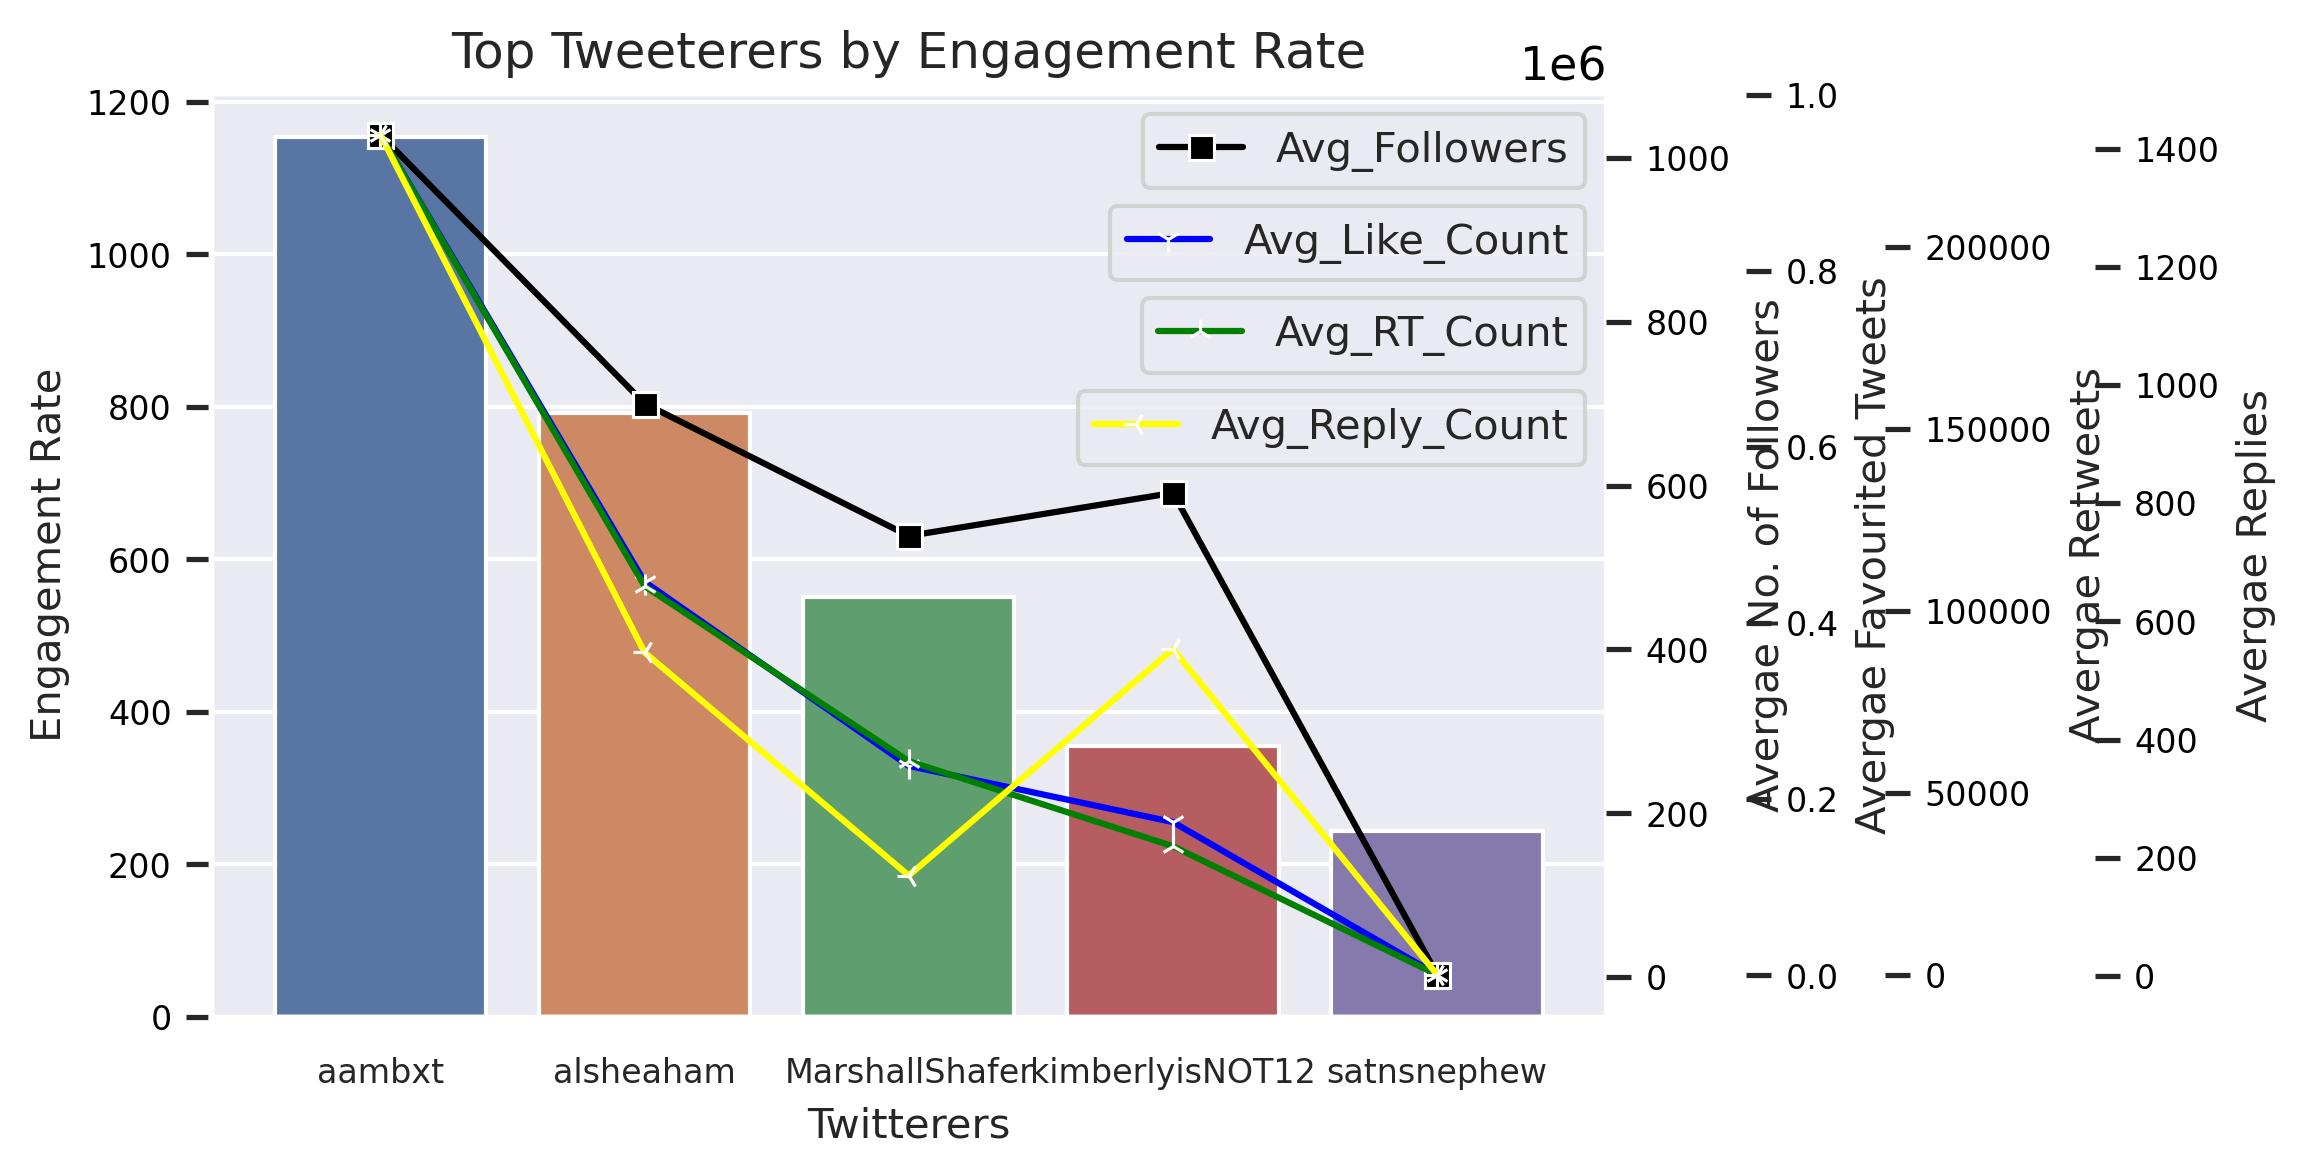

In [179]:
plt.figure(figsize = (6,4), dpi = 300)
ax = sns.barplot(x=df_RT_A_pd.RT_Status_Original_User_Screen_Name, y = df_RT_A_pd.ER)
ax2 = ax.twinx()
ax2 = sns.lineplot(x=df_RT_A_pd.RT_Status_Original_User_Screen_Name, y = df_RT_A_pd.Avg_Followers , color = 'black', marker = 's')
ax3 = ax.twinx()
ax3 = sns.lineplot(x=df_RT_A_pd.RT_Status_Original_User_Screen_Name, y = df_RT_A_pd.Avg_Like_Count , color = 'blue', marker = '1')
ax2.spines["right"].set_position(("axes", 1))
ax3.spines["right"].set_position(("axes", 1.1))
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.2))

ax4 = sns.lineplot(x=df_RT_A_pd.RT_Status_Original_User_Screen_Name, y = df_RT_A_pd.Avg_RT_Count , color = 'green', marker = '2')

ax5 = ax.twinx()
ax5= sns.lineplot(x=df_RT_A_pd.RT_Status_Original_User_Screen_Name, y = df_RT_A_pd.Avg_Reply_Count , color = 'yellow', marker = '3')
ax5.spines["right"].set_position(("axes", 1.35))


ax4.grid(visible=False)
ax5.grid(visible=False)

ax2.grid(visible=False)
ax3.grid(visible=False)
ax.set_xlabel('Twitterers', fontsize = 10)
ax.set_ylabel('Engagement Rate', fontsize = 10)
ax2.set_ylabel('Avergae No. of Followers', fontsize = 10)
ax3.set_ylabel('Avergae Favourited Tweets', fontsize = 10)
ax4.set_ylabel('Avergae Retweets', fontsize = 10)
ax5.set_ylabel('Avergae Replies', fontsize = 10)

ax.tick_params(axis='y', labelcolor='black', labelsize=8)

ax2.tick_params(axis='y', labelcolor='black', labelsize=8)
ax3.tick_params(axis='y', labelcolor='black', labelsize=8)
ax4.tick_params(axis='y', labelcolor='black', labelsize=8)
ax5.tick_params(axis='y', labelcolor='black', labelsize=8)

ax2.spines["right"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax5.spines["right"].set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

ax2.legend(['Avg_Followers'], loc='upper right', bbox_to_anchor=(1, 1) )
ax3.legend(['Avg_Like_Count'], loc='upper right', bbox_to_anchor=(1, 0.9))
ax4.legend(['Avg_RT_Count'], loc='upper right', bbox_to_anchor=(1, 0.8))
ax5.legend(['Avg_Reply_Count'], loc='upper right', bbox_to_anchor=(1, 0.7))
plt.title("Top Tweeterers by Engagement Rate")
plt.show()


